# setting up SparkContext

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
from pyspark.sql import Row
from pyspark.sql import SQLContext
import pyspark
from pyspark import SparkContext
from pyspark.sql.functions import isnan, when, count, col, avg, udf
from pyspark.ml.feature import Bucketizer, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import *

In [3]:
sc =SparkContext()
sqlContext = SQLContext(sc)

### Exploring using pandas

In [4]:
data = pd.read_csv('titanic_dataset.csv', header = 0)

In [5]:
data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis =1, inplace = True)

In [6]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


# Read Data

In [7]:
df = sqlContext.read.option("inferSchema",True).option("header",True).csv("titanic_dataset.csv")

In [8]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



### dropping columns

In [9]:
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df = df.drop(*columns_to_drop)
df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = true)



### Imputing Nan

In [10]:
# Finds columns with Nan
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+------+---+---+-----+-----+----+--------+
|Survived|Pclass|Sex|Age|SibSp|Parch|Fare|Embarked|
+--------+------+---+---+-----+-----+----+--------+
|       0|     0|  0|177|    0|    0|   0|       2|
+--------+------+---+---+-----+-----+----+--------+



In [11]:
df.agg({'age': 'mean'}).show()

+-----------------+
|         avg(age)|
+-----------------+
|29.69911764705882|
+-----------------+



In [12]:
# How to find most frequent value?????????
df.describe('Embarked').show()

+-------+--------+
|summary|Embarked|
+-------+--------+
|  count|     889|
|   mean|    null|
| stddev|    null|
|    min|       C|
|    max|       S|
+-------+--------+



In [13]:
# imputing with mean and mode
df = df.fillna('S', subset = ['Embarked'])
df = df.fillna(29.699, subset=['Age'])

### Binning

In [14]:
# binning SibSp
t = {0:0, 1:1, 2:2, 3:2, 4:2, 5:2, 8:2}
Sib = udf(lambda x: t[x], StringType())
df_buck = df.withColumn("SibSp_bucket", Sib("SibSp"))
df_buck.show()

+--------+------+------+------+-----+-----+-------+--------+------------+
|Survived|Pclass|   Sex|   Age|SibSp|Parch|   Fare|Embarked|SibSp_bucket|
+--------+------+------+------+-----+-----+-------+--------+------------+
|       0|     3|  male|  22.0|    1|    0|   7.25|       S|           1|
|       1|     1|female|  38.0|    1|    0|71.2833|       C|           1|
|       1|     3|female|  26.0|    0|    0|  7.925|       S|           0|
|       1|     1|female|  35.0|    1|    0|   53.1|       S|           1|
|       0|     3|  male|  35.0|    0|    0|   8.05|       S|           0|
|       0|     3|  male|29.699|    0|    0| 8.4583|       Q|           0|
|       0|     1|  male|  54.0|    0|    0|51.8625|       S|           0|
|       0|     3|  male|   2.0|    3|    1| 21.075|       S|           2|
|       1|     3|female|  27.0|    0|    2|11.1333|       S|           0|
|       1|     2|female|  14.0|    1|    0|30.0708|       C|           1|
|       1|     3|female|   4.0|    1| 

In [15]:
# binning Parch
t = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1}
P = udf(lambda x: t[x], StringType())
df_buck = df_buck.withColumn("Parch_bucket", P("Parch"))
df_buck.show()

+--------+------+------+------+-----+-----+-------+--------+------------+------------+
|Survived|Pclass|   Sex|   Age|SibSp|Parch|   Fare|Embarked|SibSp_bucket|Parch_bucket|
+--------+------+------+------+-----+-----+-------+--------+------------+------------+
|       0|     3|  male|  22.0|    1|    0|   7.25|       S|           1|           0|
|       1|     1|female|  38.0|    1|    0|71.2833|       C|           1|           0|
|       1|     3|female|  26.0|    0|    0|  7.925|       S|           0|           0|
|       1|     1|female|  35.0|    1|    0|   53.1|       S|           1|           0|
|       0|     3|  male|  35.0|    0|    0|   8.05|       S|           0|           0|
|       0|     3|  male|29.699|    0|    0| 8.4583|       Q|           0|           0|
|       0|     1|  male|  54.0|    0|    0|51.8625|       S|           0|           0|
|       0|     3|  male|   2.0|    3|    1| 21.075|       S|           2|           1|
|       1|     3|female|  27.0|    0|    2|

In [16]:
# dropping binned columns
columns_to_drop = ['SibSp', 'Parch']
df_buck = df_buck.drop(*columns_to_drop)
df_buck.show()

+--------+------+------+------+-------+--------+------------+------------+
|Survived|Pclass|   Sex|   Age|   Fare|Embarked|SibSp_bucket|Parch_bucket|
+--------+------+------+------+-------+--------+------------+------------+
|       0|     3|  male|  22.0|   7.25|       S|           1|           0|
|       1|     1|female|  38.0|71.2833|       C|           1|           0|
|       1|     3|female|  26.0|  7.925|       S|           0|           0|
|       1|     1|female|  35.0|   53.1|       S|           1|           0|
|       0|     3|  male|  35.0|   8.05|       S|           0|           0|
|       0|     3|  male|29.699| 8.4583|       Q|           0|           0|
|       0|     1|  male|  54.0|51.8625|       S|           0|           0|
|       0|     3|  male|   2.0| 21.075|       S|           2|           1|
|       1|     3|female|  27.0|11.1333|       S|           0|           1|
|       1|     2|female|  14.0|30.0708|       C|           1|           0|
|       1|     3|female| 

### OneHotEncode

In [17]:
df_buck.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- SibSp_bucket: string (nullable = true)
 |-- Parch_bucket: string (nullable = true)



In [18]:
from pyspark.ml.feature import OneHotEncoder
FULL_CATE = ['Survived', 'Pclass', 'Sex', 'Embarked', 'SibSp_bucket', 'Parch_bucket']
CATE_FEATURES = ['Sex', 'Embarked']
CONTI_FEATURES  = ['Age', 'Fare']

In [19]:
# encoding sex
stringIndexer = StringIndexer(inputCol="Sex", outputCol="Sex_index")
model = stringIndexer.fit(df_buck)
indexed = model.transform(df_buck)
df_buck = indexed

# onehotencoding into binary sparse vector
encoder = OneHotEncoder(dropLast=False, inputCol="Sex_index", outputCol="Sex_encoded")
model_2 = encoder.fit(df_buck)
encoded = model_2.transform(df_buck)
df_buck = encoded

In [20]:
# encoding Embarked
stringIndexer = StringIndexer(inputCol="Embarked", outputCol="Embarked_index")
model = stringIndexer.fit(df_buck)
indexed = model.transform(df_buck)
df_buck = indexed

encoder = OneHotEncoder(dropLast=False, inputCol="Embarked_index", outputCol="Embarked_vec")
model_2 = encoder.fit(df_buck)
encoded = model_2.transform(df_buck)
df_buck = encoded

In [21]:
df_buck.show()

+--------+------+------+------+-------+--------+------------+------------+---------+-------------+--------------+-------------+
|Survived|Pclass|   Sex|   Age|   Fare|Embarked|SibSp_bucket|Parch_bucket|Sex_index|  Sex_encoded|Embarked_index| Embarked_vec|
+--------+------+------+------+-------+--------+------------+------------+---------+-------------+--------------+-------------+
|       0|     3|  male|  22.0|   7.25|       S|           1|           0|      0.0|(2,[0],[1.0])|           0.0|(3,[0],[1.0])|
|       1|     1|female|  38.0|71.2833|       C|           1|           0|      1.0|(2,[1],[1.0])|           1.0|(3,[1],[1.0])|
|       1|     3|female|  26.0|  7.925|       S|           0|           0|      1.0|(2,[1],[1.0])|           0.0|(3,[0],[1.0])|
|       1|     1|female|  35.0|   53.1|       S|           1|           0|      1.0|(2,[1],[1.0])|           0.0|(3,[0],[1.0])|
|       0|     3|  male|  35.0|   8.05|       S|           0|           0|      0.0|(2,[0],[1.0])|      

# Convert dataframe to input and label

In [26]:
df_buck.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- SibSp_bucket: string (nullable = true)
 |-- Parch_bucket: string (nullable = true)
 |-- Sex_index: double (nullable = false)
 |-- Sex_encoded: vector (nullable = true)
 |-- Embarked_index: double (nullable = false)
 |-- Embarked_vec: vector (nullable = true)



In [27]:
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 

f  = ['SibSp_bucket', 'Parch_bucket']
# Convert the type
df_buck = convertColumn(df_buck, f, FloatType())
# Check the dataset
df_buck.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- SibSp_bucket: float (nullable = true)
 |-- Parch_bucket: float (nullable = true)
 |-- Sex_index: double (nullable = false)
 |-- Sex_encoded: vector (nullable = true)
 |-- Embarked_index: double (nullable = false)
 |-- Embarked_vec: vector (nullable = true)



In [28]:
feats = ['Pclass', 'Sex_encoded', 'Embarked_vec', 'SibSp_bucket', 'Parch_bucket', 'Age', 'Fare']

In [29]:
assembler =VectorAssembler(inputCols=feats, outputCol="vectorized_features")

In [30]:
assembler_df = assembler.transform(df_buck)

In [34]:
assembler_df.select('vectorized_features').show()

+--------------------+
| vectorized_features|
+--------------------+
|[3.0,1.0,0.0,1.0,...|
|[1.0,0.0,1.0,0.0,...|
|(10,[0,2,3,8,9],[...|
|[1.0,0.0,1.0,1.0,...|
|(10,[0,1,3,8,9],[...|
|(10,[0,1,5,8,9],[...|
|(10,[0,1,3,8,9],[...|
|[3.0,1.0,0.0,1.0,...|
|[3.0,0.0,1.0,1.0,...|
|[2.0,0.0,1.0,0.0,...|
|[3.0,0.0,1.0,1.0,...|
|(10,[0,2,3,8,9],[...|
|(10,[0,1,3,8,9],[...|
|[3.0,1.0,0.0,1.0,...|
|(10,[0,2,3,8,9],[...|
|(10,[0,2,3,8,9],[...|
|[3.0,1.0,0.0,0.0,...|
|(10,[0,1,3,8,9],[...|
|[3.0,0.0,1.0,1.0,...|
|(10,[0,2,4,8,9],[...|
+--------------------+
only showing top 20 rows



In [36]:
assembler_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- SibSp_bucket: float (nullable = true)
 |-- Parch_bucket: float (nullable = true)
 |-- Sex_index: double (nullable = false)
 |-- Sex_encoded: vector (nullable = true)
 |-- Embarked_index: double (nullable = false)
 |-- Embarked_vec: vector (nullable = true)
 |-- vectorized_features: vector (nullable = true)



### StandardScaler

In [38]:
scaler = StandardScaler(inputCol='vectorized_features', outputCol="features")
scaler_model = scaler.fit(assembler_df)
scaler_df = scaler_model.transform(assembler_df)
pd.set_option('display.max_colwidth', 100)

In [39]:
scaler_df.select('features').toPandas().head()

,features
0,"[3.5882109717039685, 2.0920936665593883, 0.0, 2.238383800770695, 0.0, 0.0, 1.5680682303737414, 0..."
1,"[1.1960703239013228, 0.0, 2.0920936665593883, 0.0, 2.5551127307778043, 0.0, 1.5680682303737414, ..."
2,"(3.5882109717039685, 0.0, 2.0920936665593883, 2.238383800770695, 0.0, 0.0, 0.0, 0.0, 1.999690013..."
3,"[1.1960703239013228, 0.0, 2.0920936665593883, 2.238383800770695, 0.0, 0.0, 1.5680682303737414, 0..."
4,"(3.5882109717039685, 2.0920936665593883, 0.0, 2.238383800770695, 0.0, 0.0, 0.0, 0.0, 2.691890402..."


### train test split

In [81]:
train, test = scaler_df.randomSplit([0.7,0.3])

# Model

In [59]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Survived', maxIter = 5)
log_model = lr.fit(train)
pred = log_model.transform(test)

In [45]:
pred.select('Survived', 'probability', 'prediction').show()

+--------+--------------------+----------+
|Survived|         probability|prediction|
+--------+--------------------+----------+
|       0|[0.11113394681843...|       1.0|
|       0|[0.08327034153581...|       1.0|
|       0|[0.66184645404030...|       0.0|
|       0|[0.43961486950708...|       1.0|
|       0|[0.15585690268590...|       1.0|
|       0|[0.19870020223729...|       1.0|
|       0|[0.77698438009551...|       0.0|
|       0|[0.53537494857857...|       0.0|
|       0|[0.51578250322547...|       0.0|
|       0|[0.70557102881787...|       0.0|
|       0|[0.69144734591436...|       0.0|
|       0|[0.16862345187322...|       1.0|
|       0|[0.54126378656879...|       0.0|
|       0|[0.68838090985130...|       0.0|
|       0|[0.76472907398039...|       0.0|
|       0|[0.53333286639490...|       0.0|
|       0|[0.76578139257980...|       0.0|
|       0|[0.46732611060681...|       1.0|
|       0|[0.76440576151618...|       0.0|
|       0|[0.52227230757257...|       0.0|
+--------+-

In [49]:
acc = pred.filter(pred.Survived == pred.prediction).count()/pred.count()
print(acc)

0.7793594306049823


# Hyper param Tuning

In [84]:
train.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- SibSp_bucket: float (nullable = true)
 |-- Parch_bucket: float (nullable = true)
 |-- Sex_index: double (nullable = false)
 |-- Sex_encoded: vector (nullable = true)
 |-- Embarked_index: double (nullable = false)
 |-- Embarked_vec: vector (nullable = true)
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [83]:
train = train.withColumn("label", col("Survived"))

In [85]:
#train = train.selectExpr("Survived as label", "features as features")

In [86]:
#train.show()

In [87]:
params = (ParamGridBuilder()
          .addGrid(lr.regParam, [0.01,0.5,1,1.5,2])
          .addGrid(lr.elasticNetParam, [0,0.5,1])
          .addGrid(lr.maxIter, [1,5,10])
          .build()
         )
evaluator = BinaryClassificationEvaluator()

In [88]:
cv = CrossValidator(estimator = lr, estimatorParamMaps= params,evaluator=evaluator, numFolds = 5)

In [89]:
cv_model = cv.fit(train)

In [90]:
new_pred = cv_model.transform(test)

In [92]:
acc2 = new_pred.filter(new_pred.Survived == new_pred.prediction).count()/new_pred.count()
print(acc2)

0.8175895765472313


### Feature weights

In [93]:
weights = cv_model.bestModel.coefficients

In [94]:
weights

DenseVector([-0.7317, 0.0167, 1.1621, 0.4665, 0.5712, 0.4006, -0.0409, -0.0364, -0.3812, 0.068])

In [32]:
data['Age'] = data['Age'].fillna(np.mean(data['Age']))
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

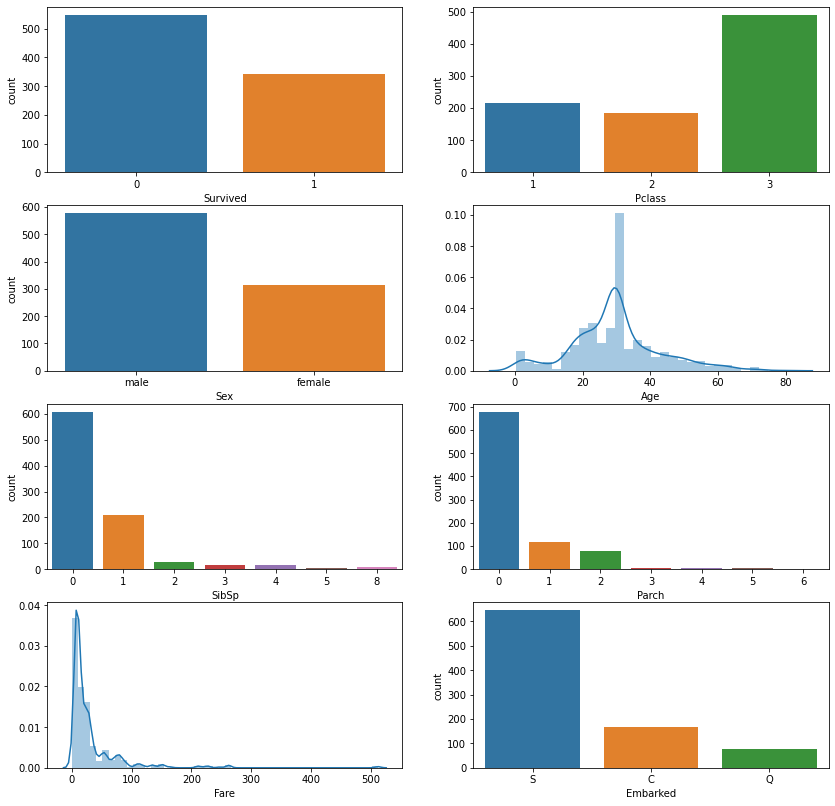

In [44]:
fig, ax = plt.subplots(4,2, figsize=(14,14))

sns.countplot(data['Survived'], ax = ax[0][0])
sns.countplot(data['Pclass'], ax = ax[0][1])
sns.countplot(data['Sex'], ax = ax[1][0])
sns.distplot(data['Age'], ax = ax[1][1])
sns.countplot(data['SibSp'], ax = ax[2][0])
sns.countplot(data['Parch'], ax = ax[2][1])
sns.distplot(data['Fare'], ax = ax[3][0])
sns.countplot(data['Embarked'], ax = ax[3][1])